In [1]:
import torch
import torch.distributions as D
import numpy as np
from typing import Callable

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

torch.set_default_dtype(torch.float64)

### Conditional bootstrap particle filter

In [2]:
def cbpf_kernel(Xref: torch.Tensor,
                yobs: torch.Tensor,
                theta: torch.Tensor,
                N: int,
                rinit:Callable,
                rprocess:Callable,
                dprocess:Callable,
                dobs:Callable):
    ''''
    Implementation of the conditional bootstrap particle filter with  ancestor sampling.

    This is a method for sampling the state trajectory of a state-space model conditioned on a reference trajectory

    Input: 
        (*) rinit: simulator function for the initial value of the state process
        (*) rprocess: function to simulate the state process forward in time: x_{t} ~ p(x_{t}|x_{t-1}, theta)
        (*) dobs: function to evaluate the density p(y_{t}|x_{t}, theta)
        (*) Xref: reference trajectory
        (*) theta: model parameter vector
        (*) yobs = [y1, ..., yT] observations
        (*) N: number of particles
    
    Output:
        (*) Xstar = [x0, x1, ...., xT] ~ p(x0:T | y0:T, theta)
    '''
    # tensor containing the trajectories of all the particles
    batchsize, T = Xref.shape
    X = torch.zeros((batchsize, T + 1, N))   
    #y = torch.zeros(T)  # append a zero at the beginning for notational convenience
    y = yobs    
    
    # 1) initialize trajectories (t = 0)
    X[:, 0, :-1] = 1.0 #rinit(theta, (N-1))
    X[:, 0, -1] = 1.0 #Xref[...,0]             # set the Nth particle determistically
    W = torch.ones((batchsize, N)) / N                 # initial weights
    
    # 2) loop over time
    for t in range(1, T+1):
        # 2.1) resample
        a_t = W.multinomial(num_samples=(N-1), replacement=True)
        #a_t = torch.stack([a[torch.randperm(len(a))] for a in a_t])
        X[:, t-1, :-1] = torch.gather(X[:, t-1, :], 1, a_t)

        # 2.2) propagate 
        X[:, t, :-1] = rprocess(X[:, t-1, :-1] , theta)
        
        # 2.3) set the Nth particle determistically to the corresponding reference value 
        X[:, t, -1] = Xref[...,t-1]   # remember Xref starts at time t = 1
        
        # 2.4) ancestor sampling
        weights = W * dprocess(Xref[...,t-1].unsqueeze(1), X[:,(t-1),:], theta, log=False)
        probs = weights / weights.sum(dim=1).unsqueeze(1)
        aNt = probs.multinomial(num_samples=1)
        
        X[:, t-1, -1] = torch.gather(X[:,t-1,:], 1, aNt).squeeze()

        # 2.5) update weights
        W = dobs(y[...,t-1], X[:,t, :], theta, log=True) # remember y starts at time t = 1
        # normalize
        W = W.softmax(dim=1)

    
    # 3) draw state trajectory
    X = X[:, 1:, :]
    b = W.multinomial(num_samples=1).expand(-1, T)
    Xstar = torch.gather(X, 2, b.unsqueeze(2)).squeeze()

    return Xstar, X

### Gaussian mixture state-space model

In [3]:
# initial state
def rinit_gmssm(theta: torch.Tensor, num_samples: int) -> torch.Tensor:
    '''
    Sampling from the distribution of the initial state
    '''
    w = D.Bernoulli(probs=theta[...,0]).sample((num_samples,)).T

    X0 = w * D.Normal(loc=1., scale=torch.sqrt(theta[...,1])).sample((num_samples,)).T +\
     (1 - w) * D.Normal(loc=1, scale=torch.sqrt(theta[...,2])).sample((num_samples,)).T
    
    return X0

# state process -- forward simulation
def rprocess_gmssm(Xold: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    '''
    Simulate the state process forward for a single time step
    '''
    w = D.Bernoulli(probs=theta[...,0]).sample((Xold.shape[1],)).T
    
    Xnew = w * D.Normal(Xold, torch.sqrt(theta[...,1]).unsqueeze(1)).sample() +\
     (1 - w) * D.Normal(Xold, torch.sqrt(theta[...,2]).unsqueeze(1)).sample()
    
    return Xnew

# state process -- density evaluation
def dprocess_gmssm(xnew: torch.Tensor, Xold: torch.Tensor, theta: torch.Tensor, log=True) -> torch.Tensor:
    '''
    evaluate p(x_{t}| x_{t-1}; theta) with
        xnew <- x_{t}
        Xold <- X_{t-1} = [x_{t-1}^1, ..., x_{t-1}^N] 

    '''
    probs = torch.cat([theta[...,0].unsqueeze(1), 1-theta[...,0].unsqueeze(1)], dim=-1)
    mix = D.Categorical(probs=probs.unsqueeze(1))
    comp = D.Normal(loc=Xold.unsqueeze(2), scale=torch.sqrt(theta[...,1:3]).unsqueeze(1))
    
    gmm = D.MixtureSameFamily(mix, comp)

    if log:
        return gmm.log_prob(xnew)
    else:     
        return gmm.log_prob(xnew).exp()

def dobs_gmssm(yt: torch.Tensor, Xt: torch.Tensor, theta: torch.Tensor, log=True) -> torch.Tensor:
    ''' 
    evaluate p(y_{t} | x_{t}; theta), where Xt = [xt_1, xt_2, ..., xt_N]
    '''
    logprob =  D.Normal(loc=Xt,
                         scale=torch.sqrt(theta[...,3].unsqueeze(1))
                         ).log_prob(yt.unsqueeze(1))
    
    
    if log:
        return logprob
    else:
        return logprob.exp()

# simulator
def simulator_gmssm(theta: torch.Tensor, T=100) -> torch.Tensor:
    '''
    Simulates from a Gaussian mixture state-space model
    '''
    # simulate hidden state
    w = D.Bernoulli(probs=theta[...,0]).sample((T,)).T
    x = torch.zeros_like(w)

    x[...,0] = w[...,0] * D.Normal(torch.ones_like(theta[...,1]),
                                                      torch.sqrt(theta[...,1])).sample() +\
     (1 - w[...,0]) * D.Normal(torch.ones_like(theta[...,2]),
                                                  torch.sqrt(theta[...,2])).sample()
    
    for t in range(1,T):
        x[...,t] = w[...,t] * D.Normal(x[...,t-1], torch.sqrt(theta[...,1])).sample() +\
     (1 - w[...,t]) * D.Normal(x[...,t-1], torch.sqrt(theta[...,2])).sample()
    
    # simulate observables
    y = D.Normal(x.T, torch.sqrt(theta[...,3])).sample()

    return y.T, x

# prior
class InverseGammaUniform():
    def __init__(self, params_p, params_sigma2_1, params_sigma2_2, params_sigma2_eps):
        self.params = {'p':params_p, 'sigma2_eta1':params_sigma2_1,
                       'sigma2_eta2':params_sigma2_2, 'sigma2_epsilon':params_sigma2_eps}
        
        self.p = D.Uniform(low=self.params['p']['lower'], 
                                             high=self.params['p']['upper'])
        
        self.sigma2_eta1 = D.InverseGamma(self.params['sigma2_eta1']['alpha'],
                                                                          self.params['sigma2_eta1']['beta'])
        
        self.sigma2_eta2 = D.InverseGamma(self.params['sigma2_eta2']['alpha'],
                                                                          self.params['sigma2_eta2']['beta'])
        
        self.sigma2_epsilon = D.InverseGamma(self.params['sigma2_epsilon']['alpha'],
                                                                          self.params['sigma2_epsilon']['beta'])
        
    def sample(self, shape: torch.Size = ()):
        theta = torch.stack([self.p.sample(shape),
                            self.sigma2_eta1.sample(shape),
                            self.sigma2_eta2.sample(shape),
                            self.sigma2_epsilon.sample(shape)
                            ], dim=-1)
        
        return theta
        
    def log_prob(self, theta):
        logprob = self.p.log_prob(theta[...,0]) + self.sigma2_eta1.log_prob(theta[...,1]) +\
        self.sigma2_eta2.log_prob(theta[...,2]) + self.sigma2_epsilon.log_prob(theta[...,3])

        return logprob

# joint density p(y1:T, x1:T, Phi) with Phi = (logit(p), log(sigma2_eta1), log(sigma2_eta2), log(sigma2_eps))
def logjointpdf_gmssm(Y, X, Phi, prior):
    '''
    Calculate log p(y1:T, x1:T, Phi) where Phi = (logit(p), log(sigma2_eta1), log(sigma2_eta2), log(sigma2_eps))

    We use the factorization log p(y1:T, x1:T, Phi) = log p(Phi) + sum_{t=1}^T log(p(y_t|x_t, Phi)) sum_{t=1}^T log(p(x_t|x_{t-1}, Phi)) with x_0 = 1

    We use the change of variable formula to calculate log p(Phi)
    '''
    ######### PRIOR ##########
    # log p(logit(p))
    p = Phi[...,0].sigmoid()
    logpdf_Phi1 = prior.p.log_prob(p) + p.log() + (1 - p).log()

    # log p(log(sigma2_eta1))
    sigma2_eta1 = Phi[...,1].exp()
    logpdf_Phi2 = prior.sigma2_eta1.log_prob(sigma2_eta1) + sigma2_eta1.log()

    # log p(log(sigma2_eta2))
    sigma2_eta2 = Phi[...,2].exp()
    logpdf_Phi3 = prior.sigma2_eta2.log_prob(sigma2_eta2) + sigma2_eta2.log()

    # log p(log(sigma2_epsilon))
    sigma2_epsilon = Phi[...,3].exp()
    logpdf_Phi4 = prior.sigma2_epsilon.log_prob(sigma2_epsilon) + sigma2_epsilon.log()

    # combine
    logpdf_prior = logpdf_Phi1 + logpdf_Phi2 + logpdf_Phi3 + logpdf_Phi4

    ######### STATE ###########
    # define x_{t-1} for t = T, ..., 1
    X_lag1 = torch.zeros_like(X)
    X_lag1[0,...] = 1.0
    X_lag1[1:,...] = X[:-1,...]

    # define the state transition kernel p(x_t| x_{t-1})
    p = p.unsqueeze(1)
    probs = torch.cat([p, 1-p], dim=-1)
    mix = D.Categorical(probs=probs.unsqueeze(1))
    comp = D.Normal(loc=X_lag1.unsqueeze(2), scale=torch.sqrt(Phi[...,1:3].exp().unsqueeze(1)))
    gmm = D.MixtureSameFamily(mix, comp)

    # calculate log density
    logpdf_X = gmm.log_prob(X)

    ########## OBSERVATION #########
    logpdf_Y =  D.Normal(loc=X, scale=torch.sqrt(sigma2_epsilon).unsqueeze(1)).log_prob(Y)
    
    ######## COMBINE ######
    logpdf = logpdf_prior + logpdf_X.squeeze().sum(dim=-1) + logpdf_Y.squeeze().sum(dim=-1)

    return logpdf

In [11]:
p = {'lower': 0.0, 'upper': 1.0}
sigma2_1 = {'alpha': 2.0, 'beta': 2.0}
sigma2_2 = {'alpha': 2.0, 'beta': 700.0}
sigma2_eps = {'alpha': 2.0, 'beta': 2.0}

prior = InverseGammaUniform(p, sigma2_1, sigma2_2, sigma2_eps)

theta = torch.tensor([0.9, 1.0, 70.0, 1.0])
#theta = prior.sample()
theta = theta.repeat((10,1))
x0 = rinit_gmssm(theta, num_samples=1000)
x1 = rprocess_gmssm(x0, theta)
#logprob = dprocess_gmssm(x1[1].unsqueeze(1), x0.T, theta)


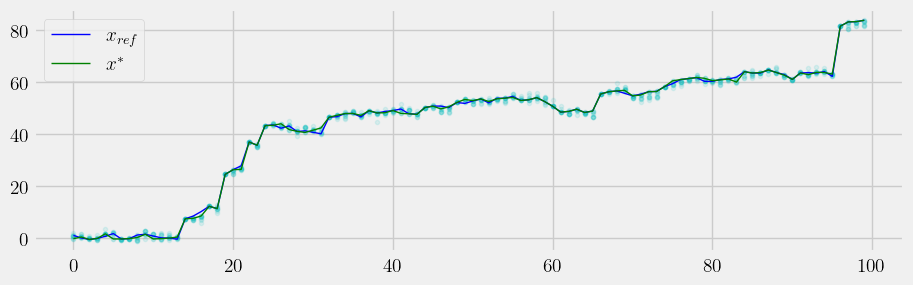

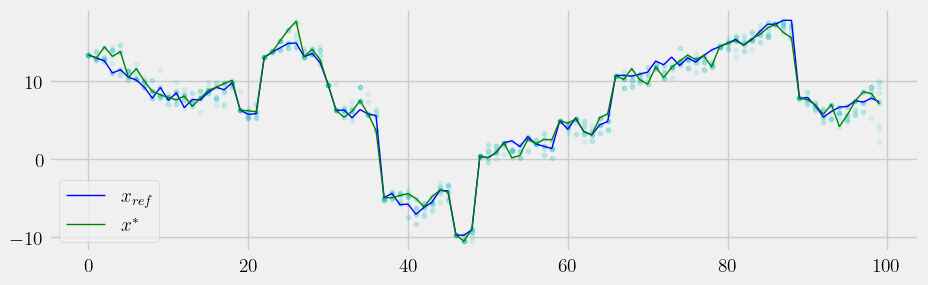

In [13]:
y, x = simulator_gmssm(theta, T=100)
A = torch.zeros((5, 1000))
Xstar, Trajs = cbpf_kernel(x, y, theta, 10, rinit_gmssm, rprocess_gmssm, dprocess_gmssm, dobs_gmssm)

for k in range(2):
    xstar, trajs = Xstar[k,...], Trajs[k,...]

    plt.figure(figsize=(10,3))
    plt.plot(torch.arange(len(x[k,...])), trajs, 'c.', lw=1, alpha=.1)
    plt.plot(x[k,...], 'b-', label=r'$x_{ref}$', lw=1.)
    plt.plot(xstar, 'g-', label=r'$x^*$', lw=1.)
    plt.legend()
    plt.show()

### PGAS with Random Walk Metropolis

In [56]:
def rescale_logitlog(theta: torch.Tensor) -> torch.Tensor:
    phi = torch.zeros_like(theta)
    phi[...,0] = theta[...,0].logit()
    phi[...,1:] = theta[...,1:].log()
    
    return phi

In [18]:
def pgas(yobs, prior, sigma=1.0, num_chains=4, num_iter=1000, num_particles=5, vafter=10):
    #### INITIALIZATION ####

    # matrix of observation for vectorized computation
    batch_size, T = yobs.shape
    Yobs = yobs.repeat((1, num_chains, 1)).reshape(batch_size, num_chains, T)
    
    # matrix of  Markov chain values over the parameter vector 
    dim_posterior = prior.sample().size(-1)
    Phi = torch.zeros((batch_size, num_chains, num_iter, dim_posterior))

    # initialize from the prior
    theta = prior.sample((batch_size, num_chains))
    #theta = torch.tensor([[0.9, 1.0, 70.0, 1.0]]).unsqueeze(1)
    phi = torch.zeros_like(theta)
    phi[...,0] = theta[...,0].logit()
    phi[...,1:] = theta[...,1:].log()
    Phi[:,:,0,:] = phi

    # initialize the hidden state 
    _, X_current = simulator_gmssm(theta.reshape(batch_size * num_chains, dim_posterior), T)
    X_current = X_current.reshape_as(Yobs)

    # evaluate log(p(y1:T, x1:T|phi)p(phi))
    logpdf_current = logjointpdf_gmssm(Y=Yobs.reshape(batch_size * num_chains, T),
                                       X=X_current.reshape(batch_size * num_chains, T),
                                       Phi=Phi[:,:,0,:].reshape(batch_size * num_chains, dim_posterior),
                                       prior=prior).reshape(batch_size, num_chains)
    
    # run Metropolis-within-Gibbs PGAS sampler
    for iter in range(1,num_iter):
        if iter % vafter == 0:
            print(".............   ", iter, "/", num_iter)

        ###### UPDATE PARAMETERS ######

        # propose Phi from a Random Walk kernel
        Phi_prop = D.Normal(loc=Phi[:,:,iter-1,:], scale=sigma).sample()
        # acceptance log probabilities
        logpdf_prop = logjointpdf_gmssm(Y=Yobs.reshape(batch_size * num_chains, T),
                                        X=X_current.reshape(batch_size * num_chains, T),
                                        Phi=Phi_prop.reshape(batch_size * num_chains, dim_posterior),
                                        prior=prior).reshape(batch_size, num_chains)
        
        acc = torch.minimum(torch.zeros_like(logpdf_prop), logpdf_prop - logpdf_current)
        
        # accept / reject
        u = D.Uniform(low=0., high=1.0).sample(acc.shape).log()
        
        Phi[:,:,iter,:][u <= acc] = Phi_prop[u <= acc]
        Phi[:,:,iter,:][u > acc] = Phi[:,:,iter-1,:][u > acc]

        # update probabilities
        logpdf_current[u <= acc] = logpdf_prop[u <= acc]  

        ####### UPDATE THE STATE #####
        theta[...,0] = Phi[:,:,iter,0].sigmoid()
        theta[...,1:] = Phi[:,:,iter,1:].exp()
        X_current, _ = cbpf_kernel(X_current.reshape(batch_size * num_chains, T),
                                Yobs.reshape(batch_size * num_chains, T),
                                theta.reshape(batch_size * num_chains, dim_posterior),
                                num_particles, rinit_gmssm, rprocess_gmssm, dprocess_gmssm, dobs_gmssm)
        
        X_current = X_current.reshape(batch_size, num_chains, T)
        

    return Phi  

In [96]:
def pgas_b(yobs, prior, propLim=[1.0, 1.0, 1.0, 1.0], num_chains=4, num_iter=1000,
          num_particles=5, vafter=10):
    #### INITIALIZATION ####

    # matrix of observation for vectorized computation
    batch_size, T = yobs.shape
    Yobs = yobs.repeat((1, num_chains, 1)).reshape(batch_size, num_chains, T)
    
    # matrix of  Markov chain values over the parameter vector 
    dim_posterior = prior.sample().size(-1)
    Phi = torch.zeros((batch_size, num_chains, num_iter, dim_posterior))

    # initialize from the prior
    #theta_current = prior.sample((batch_size, num_chains))
    theta_current = torch.tensor([[0.9, 1.0, 700.0, 2.0]]).unsqueeze(1)
    phi_current = rescale_logitlog(theta_current)
    Phi[:,:,0,:] = phi_current.clone()

    # initialize the hidden state 
    _, X_current = simulator_gmssm(theta_current.reshape(batch_size * num_chains, dim_posterior), T)
    X_current = X_current.reshape_as(Yobs)

    # evaluate log(p(y1:T, x1:T|phi)p(phi))
    logpdf_current = logjointpdf_gmssm(Y=Yobs.reshape(batch_size * num_chains, T),
                                       X=X_current.reshape(batch_size * num_chains, T),
                                       Phi=phi_current.reshape(batch_size * num_chains, dim_posterior),
                                       prior=prior).reshape(batch_size, num_chains)
    
    # run Metropolis-within-Gibbs PGAS sampler
    for iter in range(1,num_iter):
        if iter % vafter == 0:
            print(".............   ", iter, "/", num_iter)

        ###### UPDATE PARAMETERS ######
        phi_prop = phi_current.clone()
        theta_prop = theta_current.clone()

        for k in range(dim_posterior):
            # propose parameter on the original scale
            theta_prop[...,k] = D.Uniform(low=theta_current[...,k]-propLim[k]/2, high=theta_current[...,k]+propLim[k]/2).sample()
            phi_prop[...,k] = theta_prop[...,k].clone().logit() if k==0 else theta_prop[...,k].clone().log()
            
            if theta_prop[...,k] < 0:
                continue
            if k==0 and theta_prop[...,k] > 1:
                continue
            # acceptance log probabilities
            logpdf_prop = logjointpdf_gmssm(Y=Yobs.reshape(batch_size * num_chains, T),
                                            X=X_current.reshape(batch_size * num_chains, T),
                                            Phi=phi_prop.reshape(batch_size * num_chains, dim_posterior),
                                            prior=prior).reshape(batch_size, num_chains)
        
            acc = torch.minimum(torch.zeros_like(logpdf_prop), logpdf_prop - logpdf_current)
        
            # accept / reject
            u = D.Uniform(low=0., high=1.0).sample(acc.shape).log()

            phi_current[...,k][u <= acc] = phi_prop[...,k][u <= acc].clone()

            # update probabilities
            logpdf_current[u <= acc] = logpdf_prop[u <= acc]  
        
        Phi[:,:,iter,:] = phi_current.clone()

        ####### UPDATE THE STATE #####
        theta_current[...,0] = Phi[:,:,iter,0].sigmoid()
        theta_current[...,1:] = Phi[:,:,iter,1:].exp()
        X_current, _ = cbpf_kernel(X_current.reshape(batch_size * num_chains, T),
                                Yobs.reshape(batch_size * num_chains, T),
                                theta_current.reshape(batch_size * num_chains, dim_posterior),
                                num_particles, rinit_gmssm, rprocess_gmssm, dprocess_gmssm, dobs_gmssm)
        
        X_current = X_current.reshape(batch_size, num_chains, T)
        

    return Phi  

In [109]:
theta = torch.tensor([[0.9, 1.0, 700.0, 2.0]])

phi = torch.zeros_like(theta)
phi[...,0] = theta[...,0].logit()
phi[...,1:] = theta[...,1:].log()
yobs, x = simulator_gmssm(theta, T=60)

logpdf = logjointpdf_gmssm(yobs, x, phi, prior)
#samples =  pgas(yobs, prior, sigma=torch.tensor([.3, .1, 2., .3 ]), num_chains=4, num_iter=1000, num_particles=5, vafter=10)
samples = pgas_b(yobs, prior, num_iter=5000,
                propLim=np.array([.05, .1, 20.0, .1]),
                num_chains=1, vafter=500, num_particles=100)

.............    500 / 5000
.............    1000 / 5000
.............    1500 / 5000
.............    2000 / 5000
.............    2500 / 5000
.............    3000 / 5000
.............    3500 / 5000
.............    4000 / 5000
.............    4500 / 5000


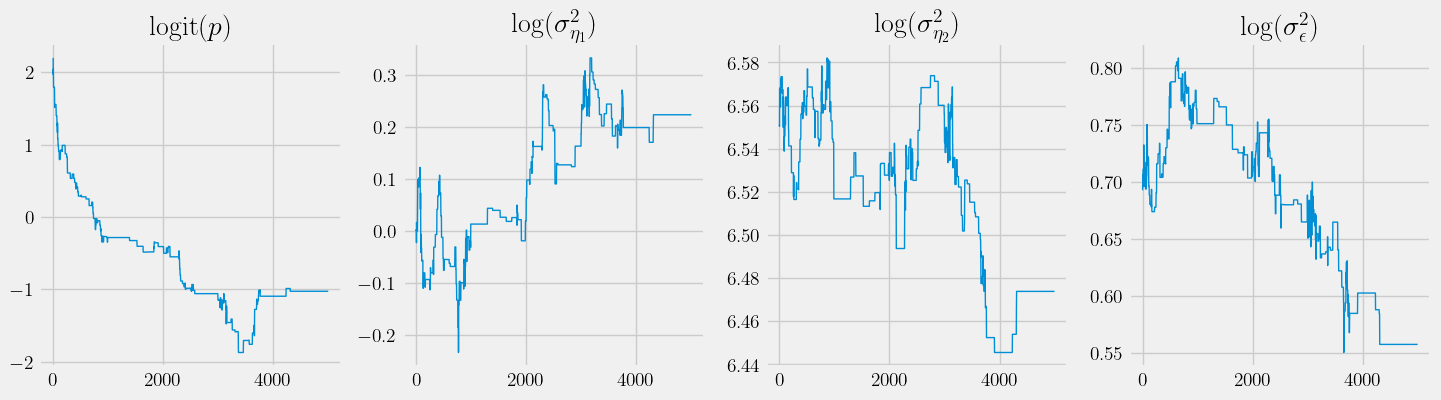

In [110]:
labels = [r'$\mathrm{logit}(p)$', r'$\log(\sigma_{\eta_1}^2)$', r'$\log(\sigma_{\eta_2}^2)$', r'$\log(\sigma_{\epsilon}^2)$']

fig = plt.figure(figsize=(16,4))

for k in range(4):
    fig.add_subplot(1, 4, k+1)
    plt.plot(torch.arange(samples.size(2)), samples[0,:,:,k].T, '-', lw=1)
    plt.title(label=labels[k])
plt.show()

In [111]:
phi

tensor([[2.1972, 0.0000, 6.5511, 0.6931]])

In [9]:
samples[...,0].unique().size(0), samples[...,1].unique().size(0), samples[...,2].unique().size(0), samples[...,3].unique().size(0)

(103, 115, 9, 69)